`cd project/seniorthesis/notebooks`

`conda list PyCO2SYS`

`pip install PyCO2SYS`

`pip install git+https://github.com/jbusecke/cmip6_preprocessing.git`

`mv *.png ../figures`

# This is the artist formerly known as `pco2_debug.ipynb` but is now `gr_20yr_PpCO2.ipynb`
So this code 

> calculates PpCO2

> plots it on a meridional slice 

> plots it as a polar stereographic projection at 0m, 10m, 100m, and 200m

All for the time period Jan 1850 to Dec 1869


#### PyCO2SYS manuscript in review

Humphreys, M. P., Lewis, E. R., Sharp, J. D., and Pierrot, D. (2021). PyCO2SYS v1.7: marine carbonate system calculations in Python. Geoscientific Model Development Discussions [preprint]. doi:10.5194/gmd-2021-159.



#### PyCO2SYS code citation

Humphreys, M. P., Sandborn, D. E., Gregor, L., Pierrot, D., van Heuven, S. M. A. C., Lewis, E. R., and Wallace, D. W. R. (2021). PyCO2SYS: marine carbonate system calculations in Python. Zenodo. doi:10.5281/zenodo.3744275.

Essentially, we are using this software to solve the marine carbonate system to specifically find the aqueous CO2



# Import packages

In [1]:
import xarray as xr
from cmip6_preprocessing.preprocessing import combined_preprocessing
import PyCO2SYS as pyco2 # i have to install this package through terminal for it to work
import intake
import matplotlib.pyplot as plt
import numpy as np
import warnings
import gsw
from cmip6_preprocessing.postprocessing import combine_datasets
from cartopy import crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
import cmocean
import matplotlib.path as mpath
from cmip6_preprocessing.postprocessing import merge_variables

In [2]:
col = intake.open_esm_datastore("https://storage.googleapis.com/cmip6/pangeo-cmip6.json")

# Functions
## You need to change the meriodional section to have units for PpCO2 -- mu atm

In [3]:
def draw_SOcustom(X,Y,Z,cmap,cbar_label,title,plot_type,**kwargs):
    
    crs_plot = ccrs.SouthPolarStereo()
    crs_source = ccrs.PlateCarree()
    
    fig,ax = plt.subplots(figsize=(10,10),subplot_kw={'projection':crs_plot})
    ax.add_feature(cfeature.LAND,zorder=10,facecolor='darkgray')
    ax.set_extent([-180, 180, -90, -30], crs_source)
    # Compute a circle in axes coordinates, which we can use as a boundary
    # for the map. We can pan/zoom as much as we like - the boundary will be
    # permanently circular.
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)
    
    ax.gridlines()
    ax.coastlines()
    
    ax.set_title(title,fontsize=14,pad = 20)
    
    if plot_type == 'contourf':
        im = ax.contourf(X,Y,Z,kwargs['clevs'],cmap=cmap,transform=crs_source)
    elif plot_type == 'pcolormesh':
        im = ax.pcolormesh(X,Y,Z,cmap=cmap,transform=crs_source,vmin=kwargs['clims'][0],vmax=kwargs['clims'][1])
    # default clims to none, if statement if clims not none
    cbar = plt.colorbar(im,orientation='horizontal',fraction=0.025,pad=0.05)
    cbar.set_label(cbar_label,fontsize=12)
    
#     plt.show()
    
    return fig,ax

def calc_PpCO2(ds):
    p = gsw.p_from_z(-1*ds['lev'], ds['y'], geo_strf_dyn_height=0, sea_surface_geopotential=0)
    insitutemp = gsw.t_from_CT(ds['so'], ds['thetao'], p)  # 0 is just a filler rn 
    results = pyco2.sys(par1=ds['talk']*1035.0,par2=ds['dissic']*1035.0,par1_type=1,par2_type=2,
                        pressure_out=0, temperature_out = ds['thetao'], pressure = p, 
                        temperature = insitutemp)
    return ds['talk'].copy(data=results['pCO2_out'])

def meridionalsection(ax,da,clims=None,title=None):
    im = ax.pcolormesh(da['y'],da['lev'],da)
    if clims is not None:
        im.set_clim(clims)
#     if kwargs == 'so':
#         ax.set_xlim([-80, -30])
#     else:
#         ax.set_xlim([-80,60]) 
    ax.set_xlim([-80,-30])
    ax.invert_yaxis()
    cbar = plt.colorbar(im,ax=ax)
    cbar.set_label('Seawater Partial Pressure of CO2 (\u03BCatm)')
    # 'Seawater Partial Pressure of CO2 (\u03BCatm)'
    ax.set_title(title)

    
def calc_sigma2(ds):
    return gsw.sigma2(ds['so'],ds['thetao'])

def meridionalsection_with_sigma2(ax,da,sigma2,clims=None,title=None):
    meridionalsection(ax,da,clims)
    ax.contour(da['y'],da['lev'],sigma2,levels=[36,36.4,36.8],colors='w')
    ax.set_title(title)

# Retrieve Models
### Merge Variables
### Find models with all variables
### Combine Datasets

In [4]:
def pick_first_member(ds_list, **kwargs):
    return ds_list[0]

variables = ['dissic','talk', 'so', 'thetao']
z_kwargs = {'consolidated': True, 'use_cftime': True}
query = dict(experiment_id=['historical'], 
             table_id=['Omon'], 
             variable_id=variables,
             grid_label=['gr'],
              source_id=['GFDL-ESM4', 'CESM2-WACCM', 'CESM2', 
                         'CESM2-FV2', 'MRI-ESM2-0', 
                         'GFDL-CM4', 'CESM2-WACCM-FV2']
            )


cat = col.search(**query)

# print(cat.df['source_id'].unique())
dset_dict_old = cat.to_dataset_dict(zarr_kwargs=z_kwargs, storage_options={'token': 'anon'},
                                preprocess=combined_preprocessing, aggregate=False)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.zstore.dcpp_init_year.version'


In [5]:
dd_new = merge_variables(dset_dict_old)

/srv/conda/envs/notebook/lib/python3.8/site-packages/cmip6_preprocessing/postprocessing.py:122: UserWarning: CMIP.NCAR.CESM2-WACCM-FV2.historical.r2i1p1f1.Omon.gr.none failed to combine with :indexes along dimension 'time' are not equal
  warnings.warn(f"{cmip6_dataset_id(ds)} failed to combine with :{e}")
/srv/conda/envs/notebook/lib/python3.8/site-packages/cmip6_preprocessing/postprocessing.py:122: UserWarning: CMIP.NCAR.CESM2-WACCM-FV2.historical.r3i1p1f1.Omon.gr.none failed to combine with :indexes along dimension 'time' are not equal
  warnings.warn(f"{cmip6_dataset_id(ds)} failed to combine with :{e}")
/srv/conda/envs/notebook/lib/python3.8/site-packages/cmip6_preprocessing/postprocessing.py:122: UserWarning: CMIP.NCAR.CESM2-FV2.historical.r2i1p1f1.Omon.gr.none failed to combine with :indexes along dimension 'time' are not equal
  warnings.warn(f"{cmip6_dataset_id(ds)} failed to combine with :{e}")
/srv/conda/envs/notebook/lib/python3.8/site-packages/cmip6_preprocessing/postproce

In [6]:
temp={}
for name,item in dd_new.items():
    #print(name)
    #print(item.data_vars)
    present = item.data_vars
    if all(i in present for i in variables):
        #print(name)
        temp[name]=item
dd_new = temp
list(dd_new.keys())

['CESM2-FV2.gr.historical.Omon.r1i1p1f1',
 'CESM2.gr.historical.Omon.r2i1p1f1',
 'CESM2.gr.historical.Omon.r11i1p1f1',
 'CESM2.gr.historical.Omon.r7i1p1f1',
 'CESM2.gr.historical.Omon.r5i1p1f1',
 'GFDL-ESM4.gr.historical.Omon.r1i1p1f1',
 'CESM2.gr.historical.Omon.r9i1p1f1',
 'CESM2-WACCM.gr.historical.Omon.r2i1p1f1',
 'MRI-ESM2-0.gr.historical.Omon.r1i2p1f1',
 'CESM2-WACCM.gr.historical.Omon.r1i1p1f1',
 'CESM2.gr.historical.Omon.r3i1p1f1',
 'CESM2.gr.historical.Omon.r8i1p1f1',
 'CESM2-WACCM-FV2.gr.historical.Omon.r1i1p1f1',
 'CESM2.gr.historical.Omon.r6i1p1f1',
 'CESM2.gr.historical.Omon.r4i1p1f1',
 'CESM2-WACCM.gr.historical.Omon.r3i1p1f1',
 'GFDL-CM4.gr.historical.Omon.r1i1p1f1',
 'CESM2.gr.historical.Omon.r1i1p1f1']

In [7]:
dd_new_new = combine_datasets(
    dd_new,
    pick_first_member,
    match_attrs=['source_id', 'grid_label', 'experiment_id', 'table_id']
)
list(dd_new_new.keys())

['CESM2-FV2.gr.historical.Omon',
 'CESM2.gr.historical.Omon',
 'GFDL-ESM4.gr.historical.Omon',
 'CESM2-WACCM.gr.historical.Omon',
 'MRI-ESM2-0.gr.historical.Omon',
 'CESM2-WACCM-FV2.gr.historical.Omon',
 'GFDL-CM4.gr.historical.Omon']

## Stereographic Projections of PpCO2


```
ds_2['pressure'] = xr.zeros_like(ds_2['thetao'])
ds_2['insitutemp'] = gsw.t_from_CT(ds_2['so'], ds_2['thetao'], ds_2['pressure']) 
conversion =  1e6/1035
results_2 = pyco2.sys(par1=ds_2.talk*conversion,par2=ds_2.dissic*conversion,par1_type=1,par2_type=2,
                    pressure_out=0, temperature_out = ds_2.thetao, pressure = ds_2['pressure'], 
                    temperature = ds_2['insitutemp'])
ds_2['pco2_out'] = ds_2['talk'].copy(data=results_2['pCO2_out'])
ds_2['pco2_out'].plot()
```

So I have realized that just using `ds['pressure'] = xr.zeros_like(ds['thetao'])` doesn't actually give the pressure I need and I need to implement `p = gsw.p_from_z(-1*d['lev'], d['pressure'], geo_strf_dyn_height=0, sea_surface_geopotential=0)` but in a way where the dimensions are (y: 180, x: 360)

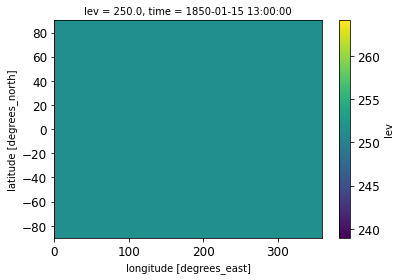

In [20]:
d = dd_new_new['CESM2-FV2.gr.historical.Omon'].isel(time = 0, lev = 10)
# d.lev
d['pressure'] = xr.zeros_like(d['thetao'])
p = gsw.p_from_z(-1*d['lev'], d['pressure'], geo_strf_dyn_height=0, sea_surface_geopotential=0)
p.plot()
# p.isel(time = 0, lev = 0).plot()
# d['insitutemp'] = gsw.t_from_CT(d['so'], d['thetao'], p) 
# # print(d['insitutemp'])
# conversion =  1e6/1035
# results = pyco2.sys(par1=d.talk*conversion,par2=d.dissic*conversion,par1_type=1,par2_type=2,
#     pressure_out=0, temperature_out = d.thetao, pressure = p, 
#     temperature = d['insitutemp'])

(array([907200., 388800., 259200., 129600.,  64800.,  64800.,  64800.,
         64800.,  64800., 129600.]),
 array([   0.        ,  560.2385695 , 1120.47713901, 1680.71570851,
        2240.95427801, 2801.19284751, 3361.43141702, 3921.66998652,
        4481.90855602, 5042.14712552, 5602.38569503]),
 <BarContainer object of 10 artists>)

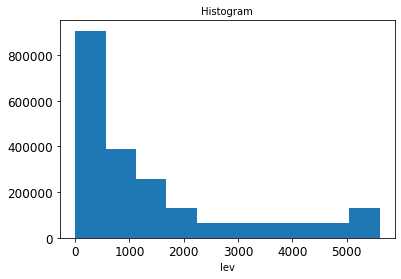

In [23]:
d = dd_new_new['CESM2-FV2.gr.historical.Omon'].isel(time = 0)
# d.lev
d['pressure'] = xr.zeros_like(d['thetao'])
p = gsw.p_from_z(-1*d['lev'], d['pressure'], geo_strf_dyn_height=0, sea_surface_geopotential=0)
p.plot()
# p.isel(time = 0, lev = 0).plot()
# d['insitutemp'] = gsw.t_from_CT(d['so'], d['thetao'], p) 
# # print(d['insitutemp'])
# conversion =  1e6/1035
# results = pyco2.sys(par1=d.talk*conversion,par2=d.dissic*conversion,par1_type=1,par2_type=2,
#     pressure_out=0, temperature_out = d.thetao, pressure = p, 
#     temperature = d['insitutemp'])

In [26]:
d = dd_new_new['CESM2-FV2.gr.historical.Omon'].isel(time = 0)
# d.lev
d['pressure'] = xr.zeros_like(d['thetao'])
p = gsw.p_from_z(-1*d['lev'], d['pressure'], geo_strf_dyn_height=0, sea_surface_geopotential=0)
p
# p.isel(time = 0, lev = 0).plot()
# d['insitutemp'] = gsw.t_from_CT(d['so'], d['thetao'], p) 
# # print(d['insitutemp'])
# conversion =  1e6/1035
# results = pyco2.sys(par1=d.talk*conversion,par2=d.dissic*conversion,par1_type=1,par2_type=2,
#     pressure_out=0, temperature_out = d.thetao, pressure = p, 
#     temperature = d['insitutemp'])

<xarray.DataArray 'lev' (lev: 33, y: 180, x: 360)>
dask.array<p_from_z, shape=(33, 180, 360), dtype=float64, chunksize=(33, 180, 360), chunktype=numpy.ndarray>
Coordinates:
  * lev      (lev) float64 0.0 10.0 20.0 30.0 ... 4e+03 4.5e+03 5e+03 5.5e+03
    time     object 1850-01-15 13:00:00
  * y        (y) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * x        (x) float64 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
    lon      (x, y) float64 0.5 0.5 0.5 0.5 0.5 ... 359.5 359.5 359.5 359.5
    lat      (x, y) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5

#### 0m

/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.

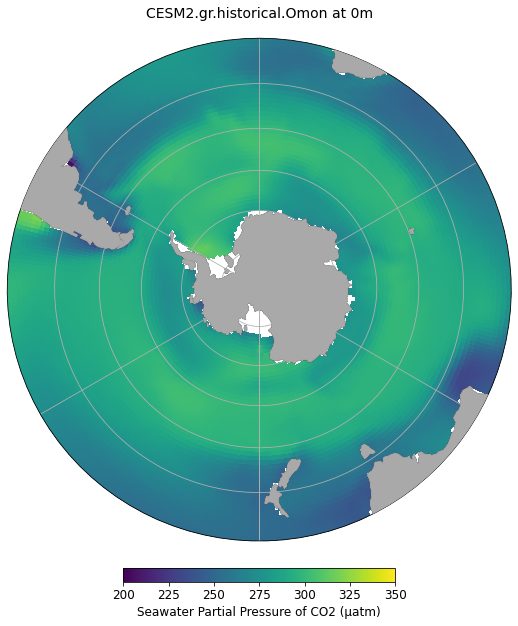

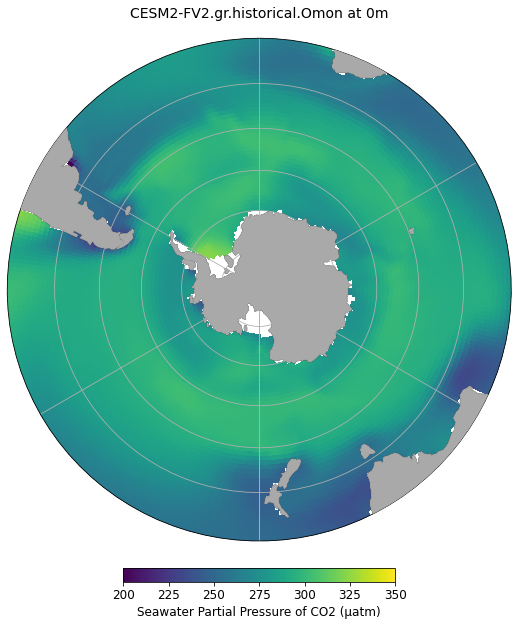

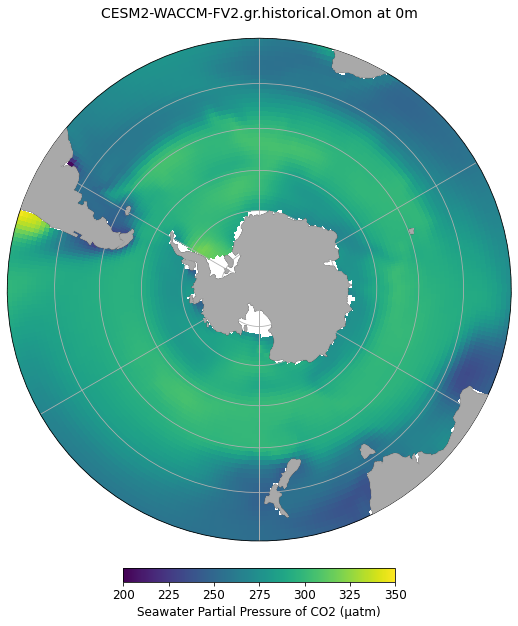

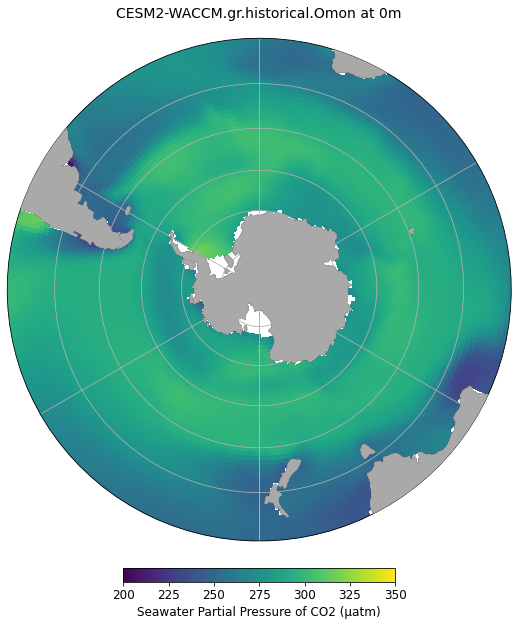

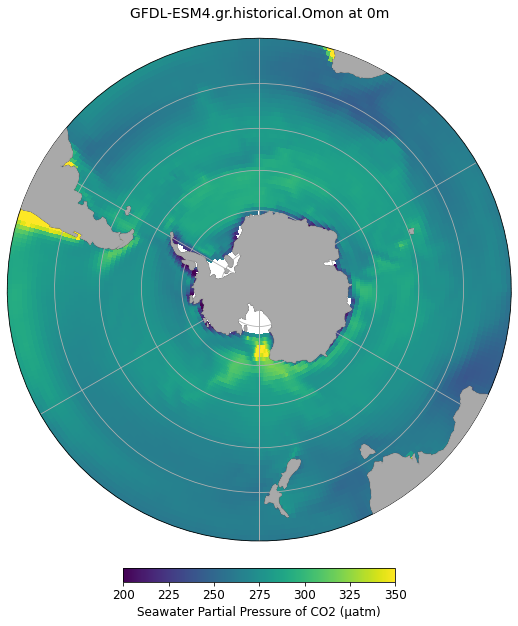

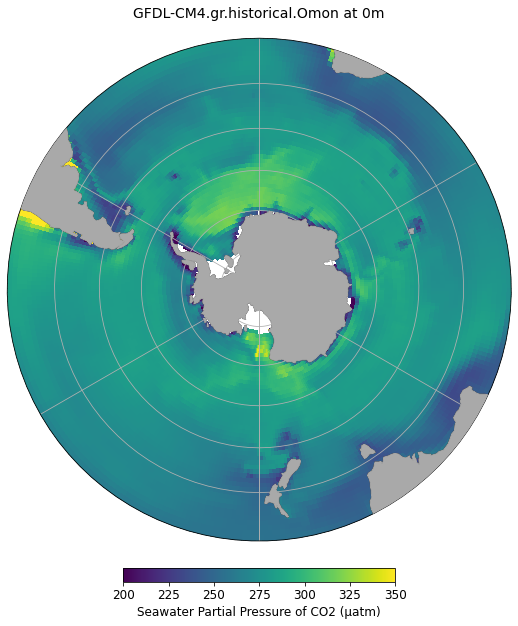

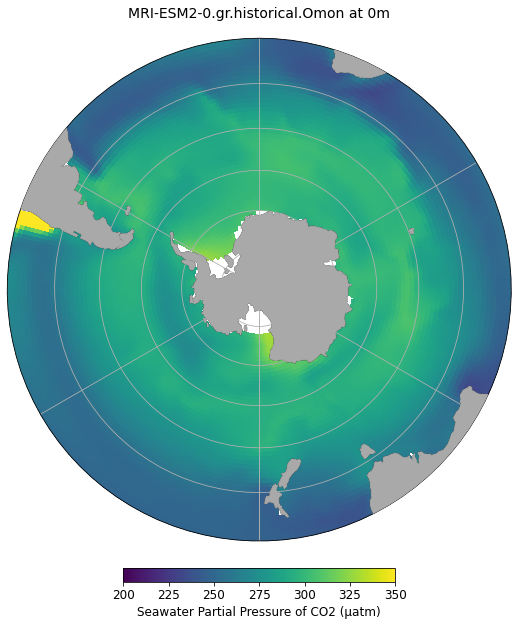

In [16]:
plt.rc('font', size = 12)
plt.rc('axes', titlesize= 10)    
plt.rc('axes', labelsize= 10)
plt.rc('figure', titlesize=14)

#loop over each key, value pair of the dictionary
ax_idx = 0 # index for your axes array
for name, ds in dd_new_new.items():

    # I selected the depth first 
    # in the hopes that having less values to average
    # it would go faster
    
    ds = ds.isel(lev = 0)
    ds = ds.isel(time = slice(0, 239)).mean('time', keep_attrs=True)
    
    ds['pressure'] = xr.zeros_like(ds['thetao'])
    p = gsw.p_from_z(-1*ds['lev'], ds['pressure'], geo_strf_dyn_height=0, sea_surface_geopotential=0)
#     print(ds['pressure'])
    ds['insitutemp'] = gsw.t_from_CT(ds['so'], ds['thetao'], p) 
#     print(ds['insitutemp'])
    conversion =  1e6/1035
    results = pyco2.sys(par1=ds.talk*conversion,par2=ds.dissic*conversion,par1_type=1,par2_type=2,
                    pressure_out=0, temperature_out = ds.thetao, pressure = p, 
                    temperature = ds['insitutemp'])
    ds['pco2_out'] = ds['talk'].copy(data=results['pCO2_out'])
    surf = ds.pco2_out
#     print(surf)
    lat = ds.lat.transpose('y','x')
# #     print(lat)
    lon = ds.lon.transpose('y','x')
    draw_SOcustom(lon,lat,surf,cmap='viridis',cbar_label='Seawater Partial Pressure of CO2 (\u03BCatm)',
                  title=name+ ' at 0m',
                  plot_type='pcolormesh',clims=[200,350])

#     ax_idx += 1 # this is a nifty python trick to increment a variable by one


#### 10m

/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.

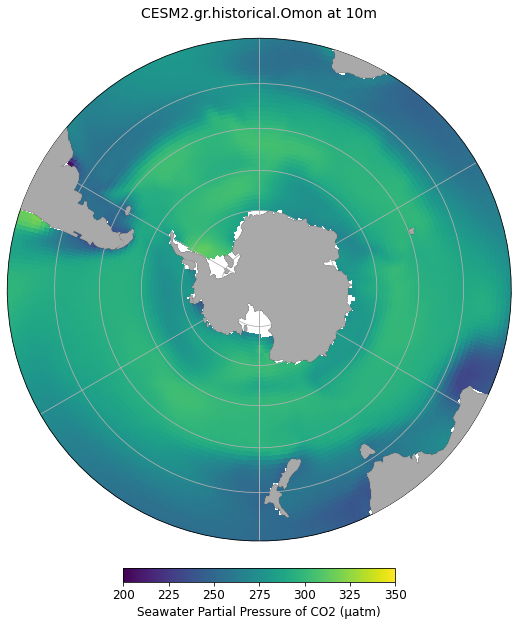

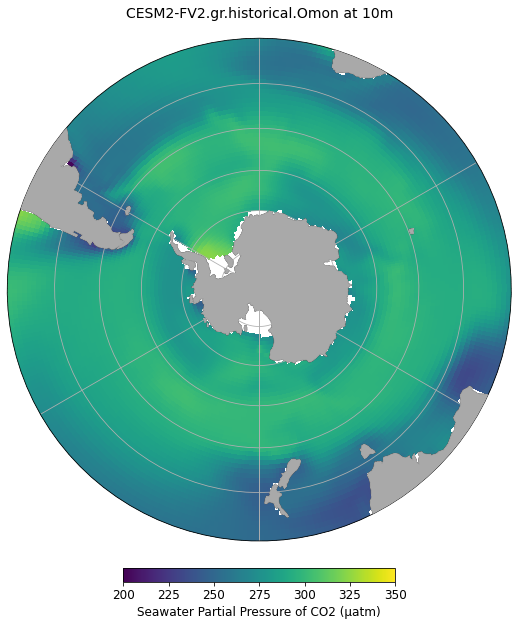

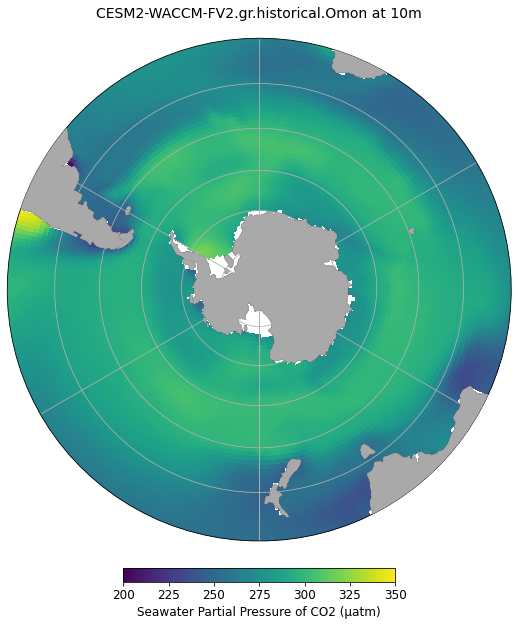

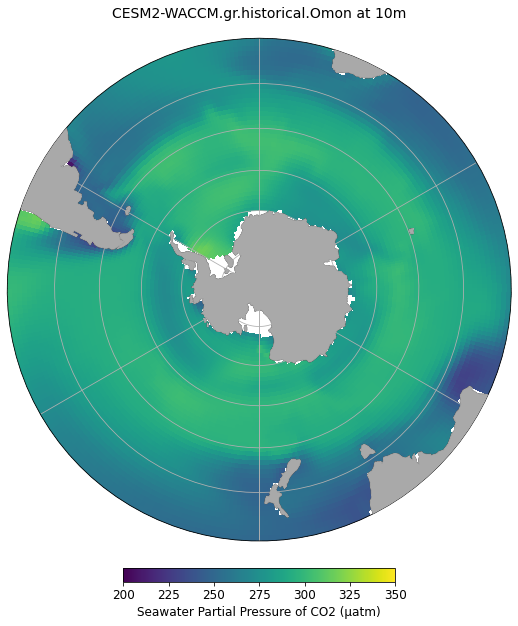

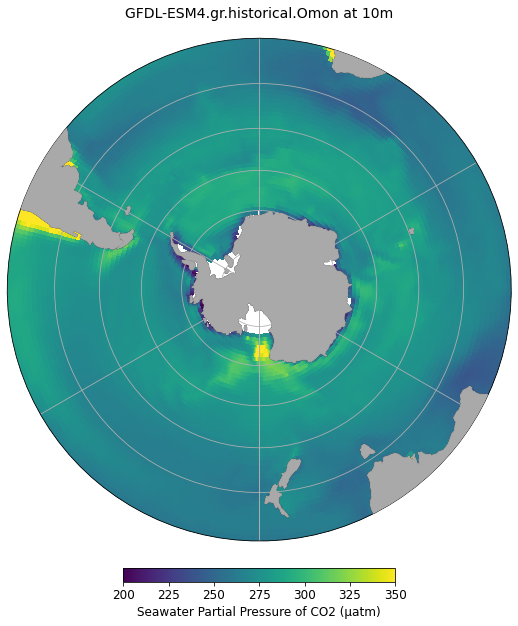

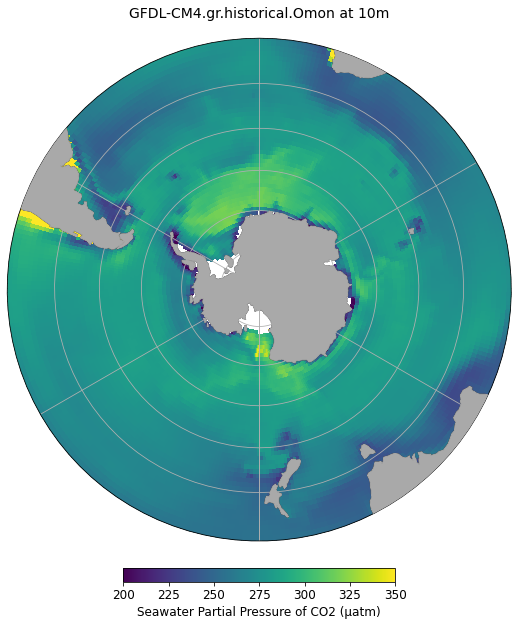

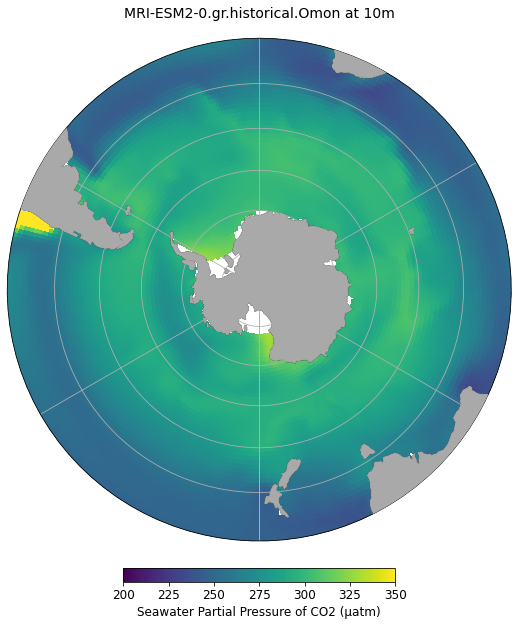

In [27]:
plt.rc('font', size = 12)
plt.rc('axes', titlesize= 10)    
plt.rc('axes', labelsize= 10)
plt.rc('figure', titlesize=14)

#loop over each key, value pair of the dictionary
ax_idx = 0 # index for your axes array
for name, ds in dd_new_new.items():

    ds = ds.isel(lev = 1)
    ds = ds.isel(time = slice(0, 239)).mean('time', keep_attrs=True)
    
    ds['pressure'] = xr.zeros_like(ds['thetao'])
#     print(ds['pressure'])
    p = gsw.p_from_z(-1*ds['lev'], ds['pressure'], geo_strf_dyn_height=0, sea_surface_geopotential=0)
    ds['insitutemp'] = gsw.t_from_CT(ds['so'], ds['thetao'], p) 
#     print(ds['insitutemp'])
    conversion =  1e6/1035
    results = pyco2.sys(par1=ds.talk*conversion,par2=ds.dissic*conversion,par1_type=1,par2_type=2,
                    pressure_out=0, temperature_out = ds.thetao, pressure = p, 
                    temperature = ds['insitutemp'])
    ds['pco2_out'] = ds['talk'].copy(data=results['pCO2_out'])
    surf = ds.pco2_out
#     print(surf)
    lat = ds.lat.transpose('y','x')
# #     print(lat)
    lon = ds.lon.transpose('y','x')
    draw_SOcustom(lon,lat,surf,cmap='viridis',cbar_label='Seawater Partial Pressure of CO2 (\u03BCatm)',
                  title=name+ ' at 10m',
                  plot_type='pcolormesh',clims=[200,350])

#     ax_idx += 1 # this is a nifty python trick to increment a variable by one

#### 100m

/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.

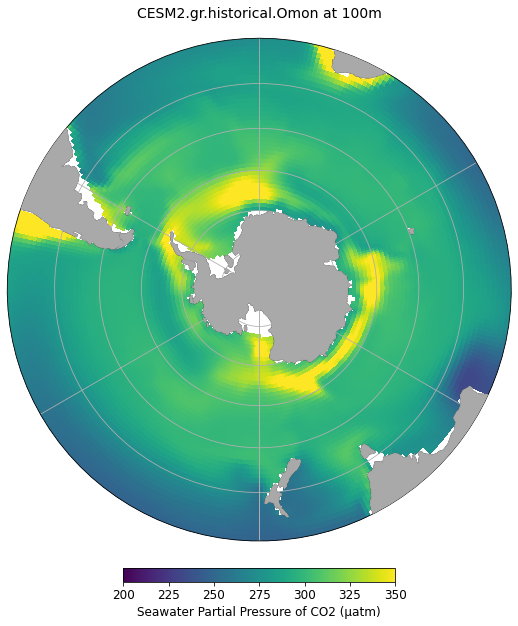

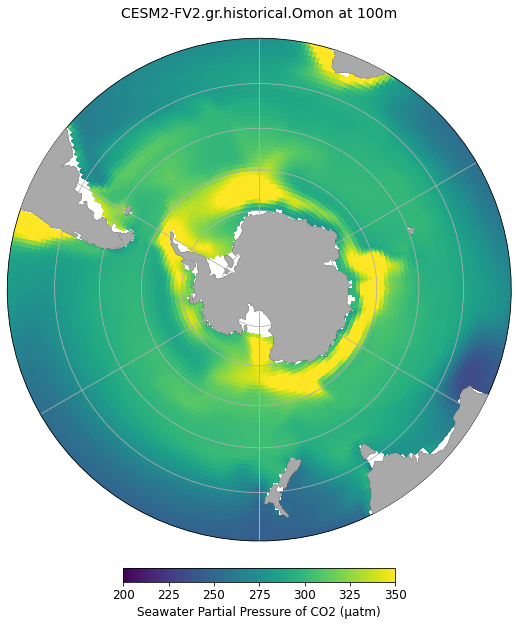

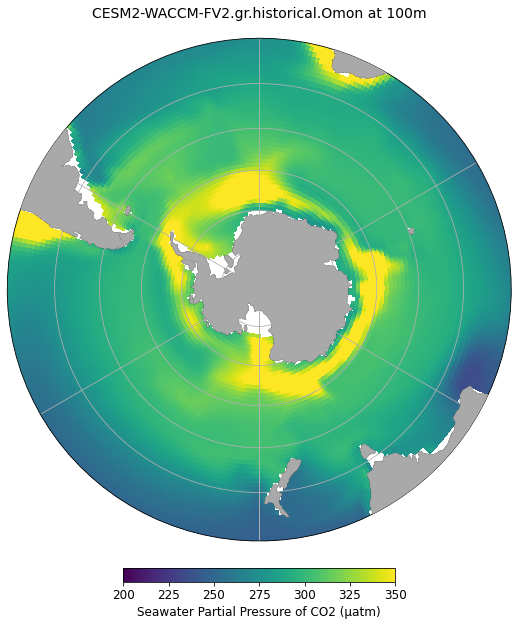

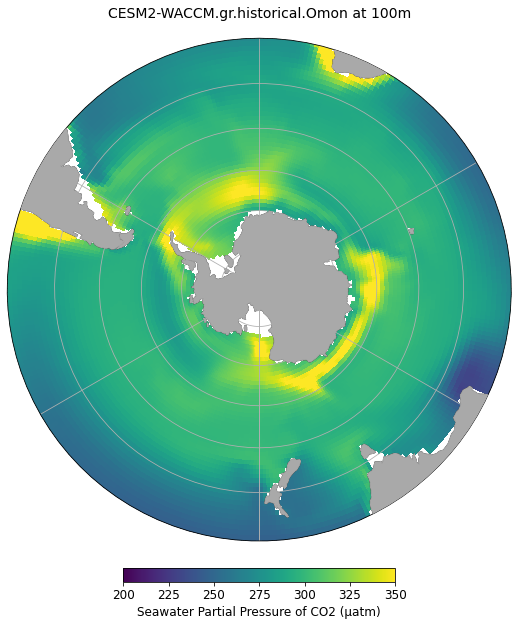

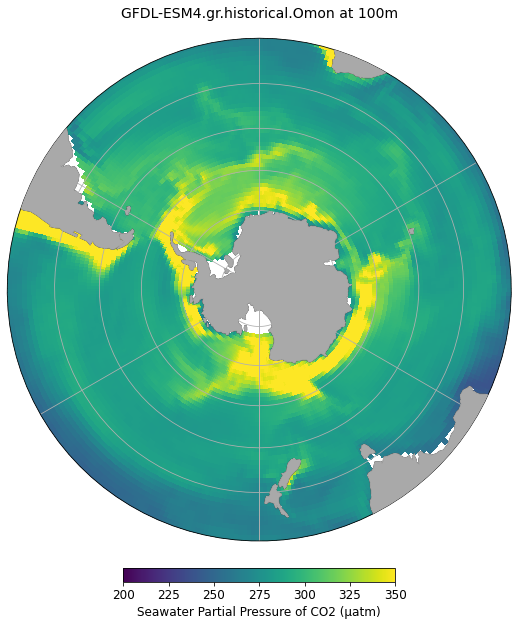

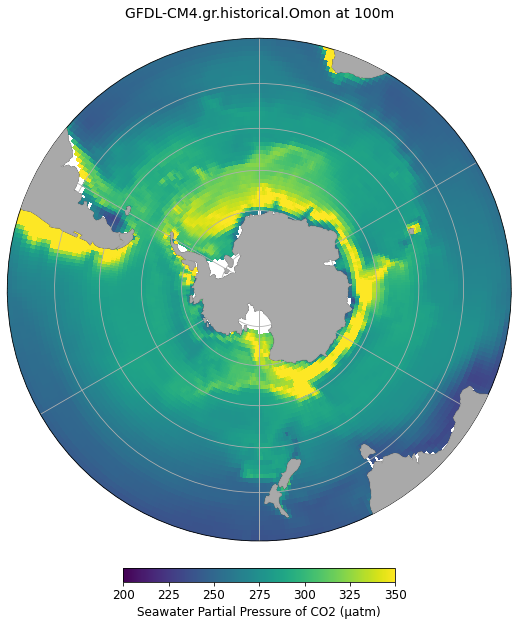

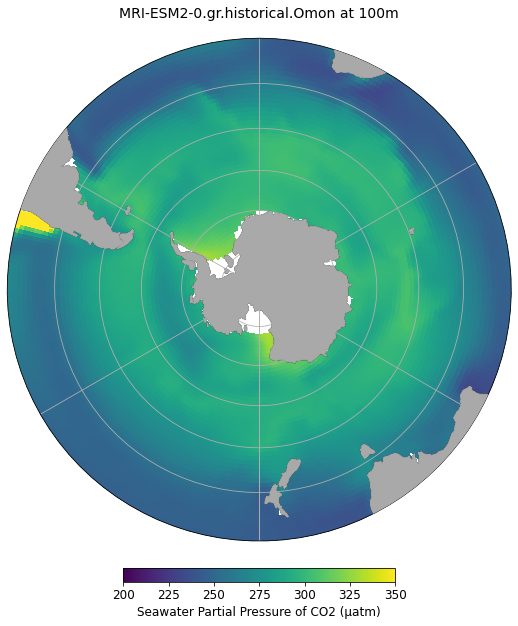

In [28]:
plt.rc('font', size = 12)
plt.rc('axes', titlesize= 10)    
plt.rc('axes', labelsize= 10)
plt.rc('figure', titlesize=14)

#loop over each key, value pair of the dictionary
ax_idx = 0 # index for your axes array
for name, ds in dd_new_new.items():

    ds = ds.isel(lev = 6)
    ds = ds.isel(time = slice(0, 239)).mean('time', keep_attrs=True)
    
    ds['pressure'] = xr.zeros_like(ds['thetao'])
    p = gsw.p_from_z(-1*ds['lev'], ds['pressure'], geo_strf_dyn_height=0, sea_surface_geopotential=0)
#     print(ds['pressure'])
    ds['insitutemp'] = gsw.t_from_CT(ds['so'], ds['thetao'], p) 
#     print(ds['insitutemp'])
    conversion =  1e6/1035
    results = pyco2.sys(par1=ds.talk*conversion,par2=ds.dissic*conversion,par1_type=1,par2_type=2,
                    pressure_out=0, temperature_out = ds.thetao, pressure = p, 
                    temperature = ds['insitutemp'])
    ds['pco2_out'] = ds['talk'].copy(data=results['pCO2_out'])
    surf = ds.pco2_out
#     print(surf)
    lat = ds.lat.transpose('y','x')
# #     print(lat)
    lon = ds.lon.transpose('y','x')
    draw_SOcustom(lon,lat,surf,cmap='viridis',cbar_label='Seawater Partial Pressure of CO2 (\u03BCatm)',
                  title=name+ ' at 100m',
                  plot_type='pcolormesh',clims=[200,350])

#     ax_idx += 1 # this is a nifty python trick to increment a variable by one

#### 200m

/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.

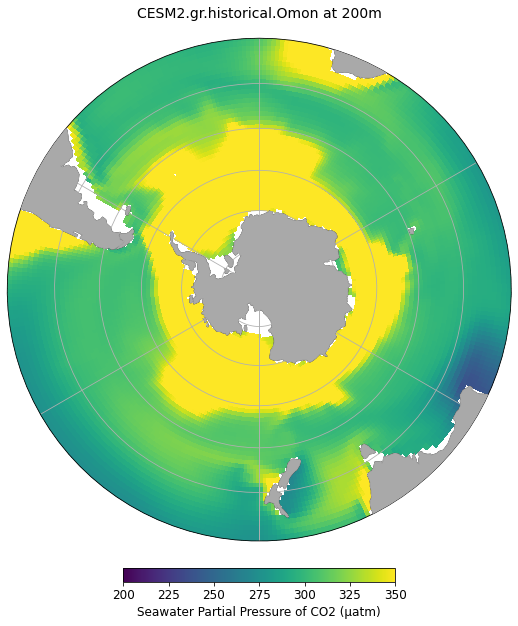

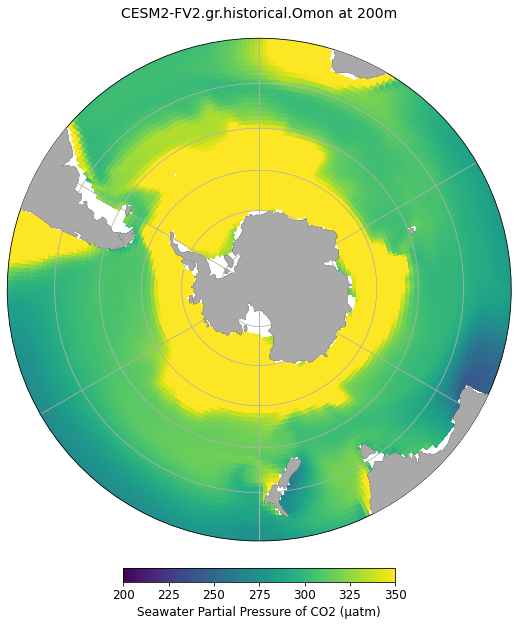

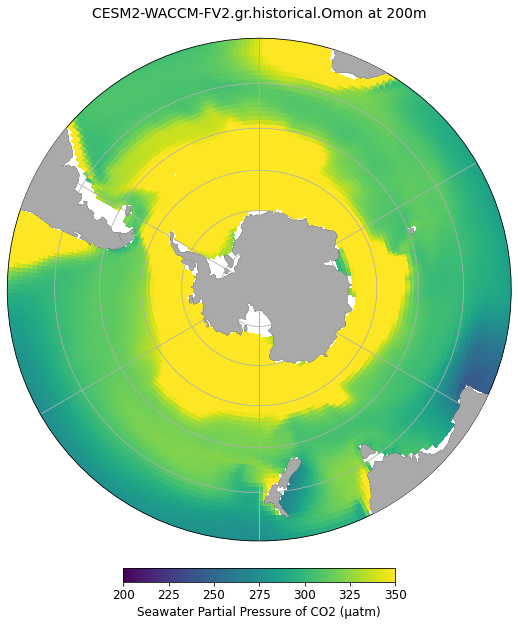

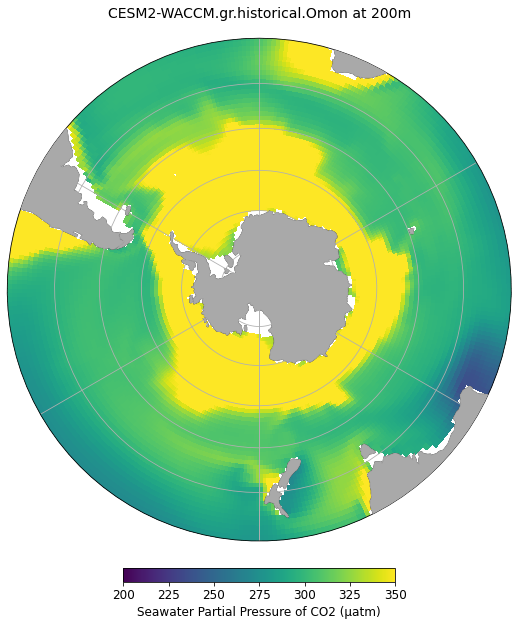

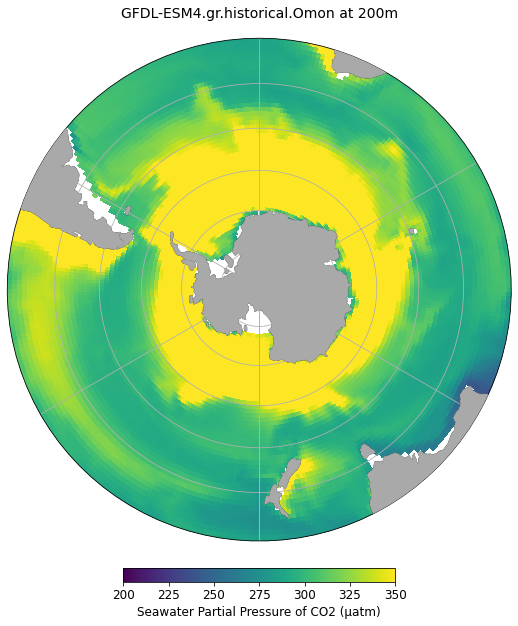

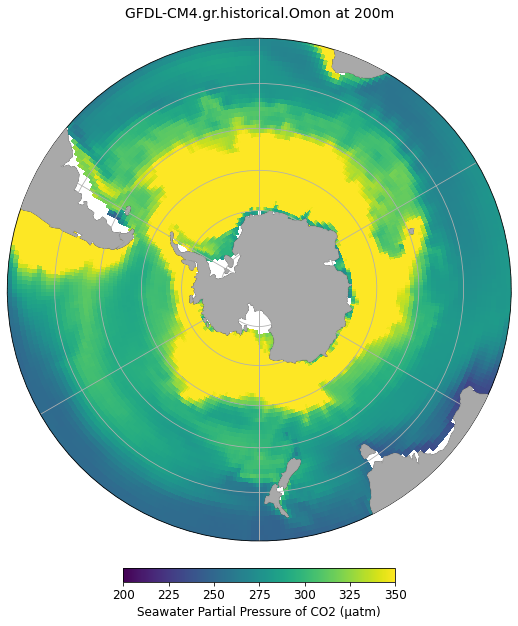

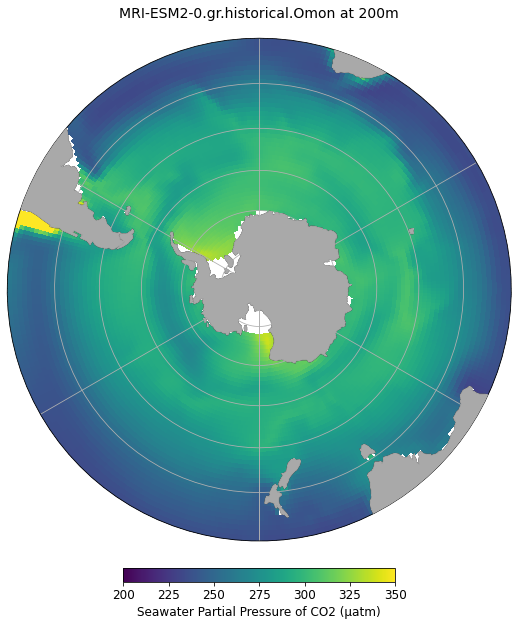

In [29]:
plt.rc('font', size = 12)
plt.rc('axes', titlesize= 10)    
plt.rc('axes', labelsize= 10)
plt.rc('figure', titlesize=14)

#loop over each key, value pair of the dictionary
ax_idx = 0 # index for your axes array
for name, ds in dd_new_new.items():

    ds = ds.isel(lev = 9)
    ds = ds.isel(time = slice(0, 239)).mean('time', keep_attrs=True)
    
    ds['pressure'] = xr.zeros_like(ds['thetao'])
    p = gsw.p_from_z(-1*ds['lev'], ds['pressure'], geo_strf_dyn_height=0, sea_surface_geopotential=0)
#     print(ds['pressure'])
    ds['insitutemp'] = gsw.t_from_CT(ds['so'], ds['thetao'], p) 
#     print(ds['insitutemp'])
    conversion =  1e6/1035
    results = pyco2.sys(par1=ds.talk*conversion,par2=ds.dissic*conversion,par1_type=1,par2_type=2,
                    pressure_out=0, temperature_out = ds.thetao, pressure = p, 
                    temperature = ds['insitutemp'])
    ds['pco2_out'] = ds['talk'].copy(data=results['pCO2_out'])
    surf = ds.pco2_out
#     print(surf)
    lat = ds.lat.transpose('y','x')
# #     print(lat)
    lon = ds.lon.transpose('y','x')
    draw_SOcustom(lon,lat,surf,cmap='viridis',cbar_label='Seawater Partial Pressure of CO2 (\u03BCatm)',
                  title=name+ ' at 200m',
                  plot_type='pcolormesh',clims=[200,350])

#     ax_idx += 1 # this is a nifty python trick to increment a variable by one

# Meridional Slices

## Entire Profile

In [ ]:
fig_pco2, axarr_pco2 = plt.subplots(nrows = 4, ncols = 2, figsize=[15,12])
fig_pco2.tight_layout(pad = 3.5)
plt.rc('font', size = 12)
plt.rc('axes', titlesize= 10)    
plt.rc('axes', labelsize= 10)
plt.rc('figure', titlesize=14)

#loop over each key, value pair of the dictionary
ax_idx = 0 # index for your axes array
for name, ds_pco2 in dd_new_new.items():
    ax = axarr_pco2.flat[ax_idx]
    ds_pco2 = ds_pco2.sel(x=slice(180,200)).mean('x',keep_attrs=True)
    ds_pco2 = ds_pco2.isel(time = slice(0, 239)).mean('time', keep_attrs=True)

    pco2 = calc_PpCO2(ds_pco2)
    sigma2 = calc_sigma2(ds_pco2)
    meridionalsection_with_sigma2(ax,pco2,sigma2, clims=[500,2000],title=name)
    ax_idx += 1 # this is a nifty python trick to increment a variable by one

## Just Southern Ocean
I wasn't sure how to change the function to accept an argument that determines the x-limits, so I literally just changed the function to do this.

/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
<ipython-input-3-a5054a737bec>:44: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax.pcolormesh(da['y'],da['lev'],da)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/numpy_compat.py:39: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
<ipython-input-3-a5054a737bec>:44: MatplotlibDeprecationWarning: shading='flat' when X and Y have t

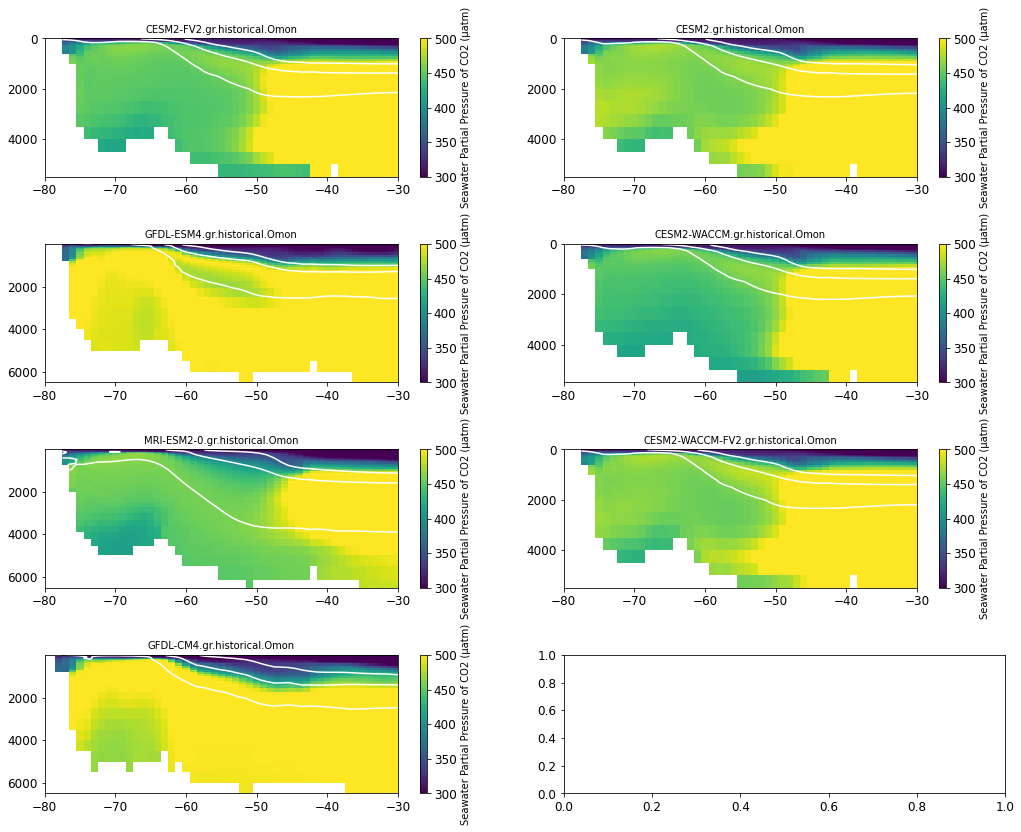

In [13]:
fig_pco2, axarr_pco2 = plt.subplots(nrows = 4, ncols = 2, figsize=[15,12])
fig_pco2.tight_layout(pad = 3.5)
plt.rc('font', size = 12)
plt.rc('axes', titlesize= 10)    
plt.rc('axes', labelsize= 10)
plt.rc('figure', titlesize=14)

#loop over each key, value pair of the dictionary
ax_idx = 0 # index for your axes array
for name, ds_pco2 in dd_new_new.items():
    ax = axarr_pco2.flat[ax_idx]
    ds_pco2 = ds_pco2.sel(x=slice(180,200)).mean('x',keep_attrs=True)
    ds_pco2 = ds_pco2.isel(time = slice(0, 239)).mean('time', keep_attrs=True)

    pco2 = calc_PpCO2(ds_pco2)
    sigma2 = calc_sigma2(ds_pco2)
    meridionalsection_with_sigma2(ax,pco2,sigma2, clims=[300,500],title=name)
    ax_idx += 1 # this is a nifty python trick to increment a variable by one

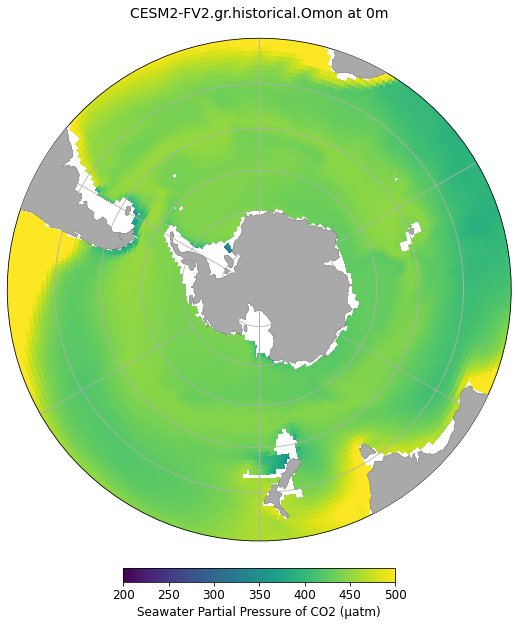

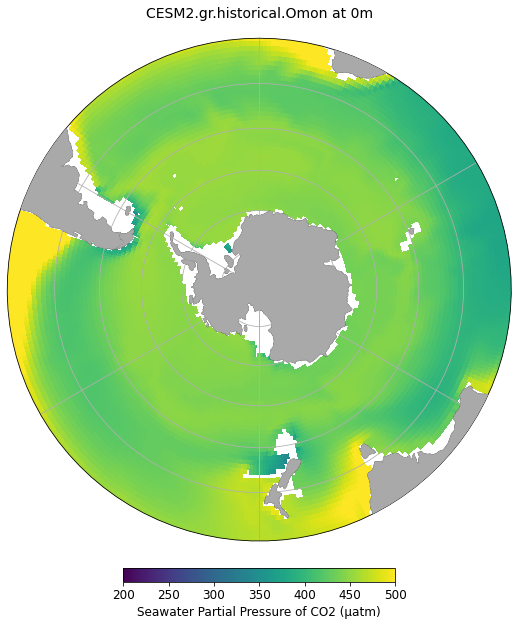

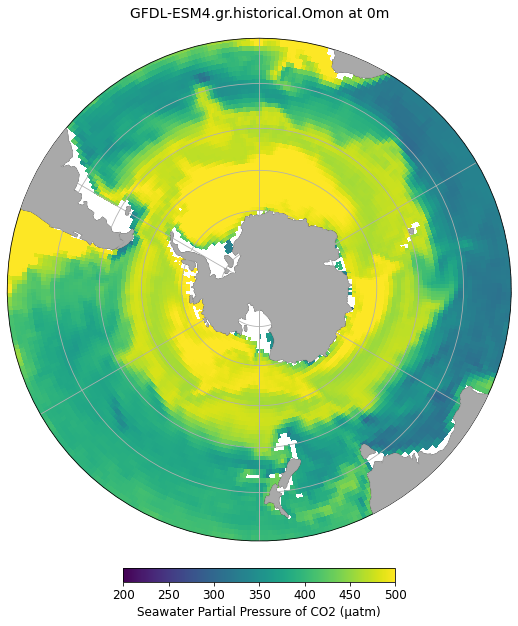

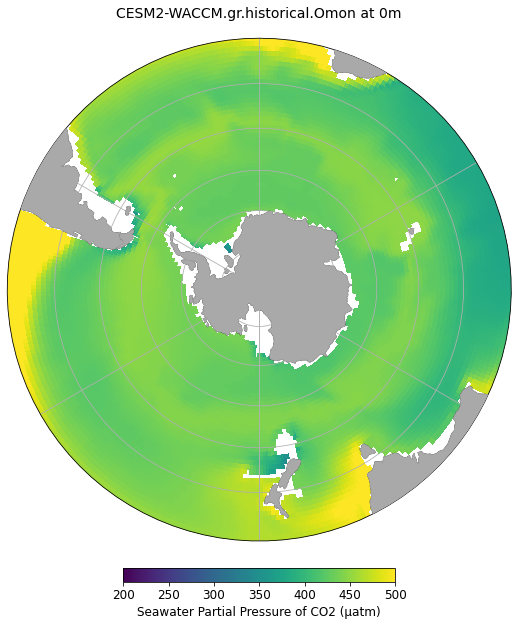

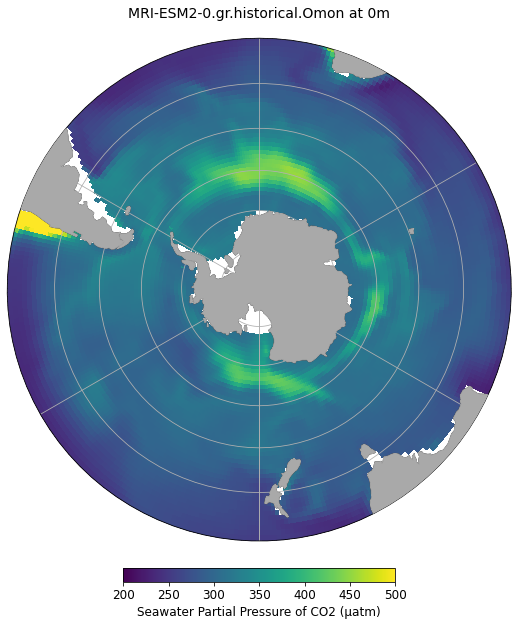

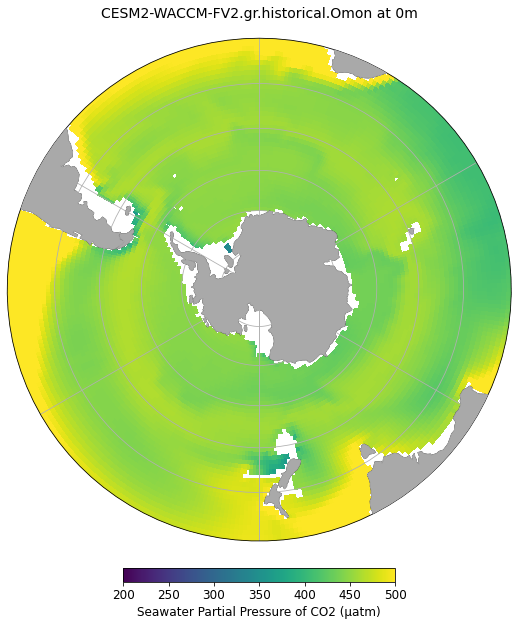

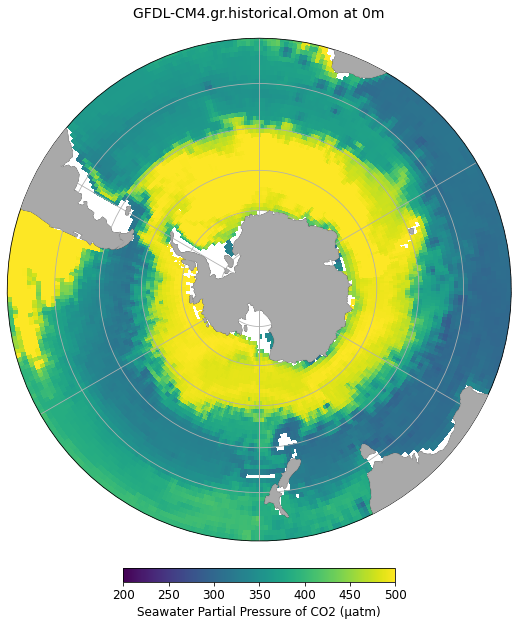

In [11]:
plt.rc('font', size = 12)
plt.rc('axes', titlesize= 10)    
plt.rc('axes', labelsize= 10)
plt.rc('figure', titlesize=14)

#loop over each key, value pair of the dictionary
ax_idx = 0 # index for your axes array
for name, ds in dd_new_new.items():

    # I selected the depth first 
    # in the hopes that having less values to average
    # it would go faster
    
    ds = ds.isel(lev = 16, time = 0)
    # .sel(lev = 800, method = nearest)
#     ds = ds.isel(time = slice(0, 239)).mean('time', keep_attrs=True)
    
    ds['pressure'] = xr.zeros_like(ds['thetao'])
    p = gsw.p_from_z(-1*ds['lev'], ds['pressure'], geo_strf_dyn_height=0, sea_surface_geopotential=0)
#     print(ds['pressure'])
    ds['insitutemp'] = gsw.t_from_CT(ds['so'], ds['thetao'], p) 
#     print(ds['insitutemp'])
    conversion =  1e6/1035
    results = pyco2.sys(par1=ds.talk*conversion,par2=ds.dissic*conversion,par1_type=1,par2_type=2,
                    pressure_out=0, temperature_out = ds.thetao, pressure = p, 
                    temperature = ds['insitutemp'])
    ds['pco2_out'] = ds['talk'].copy(data=results['pCO2_out'])
    surf = ds.pco2_out
#     print(surf)
    lat = ds.lat.transpose('y','x')
# #     print(lat)
    lon = ds.lon.transpose('y','x')
    draw_SOcustom(lon,lat,surf,cmap='viridis',cbar_label='Seawater Partial Pressure of CO2 (\u03BCatm)',
                  title=name+ ' at 0m',
                  plot_type='pcolormesh',clims=[200,500])

#     ax_idx += 1 # this is a nifty python trick to increment a variable by one


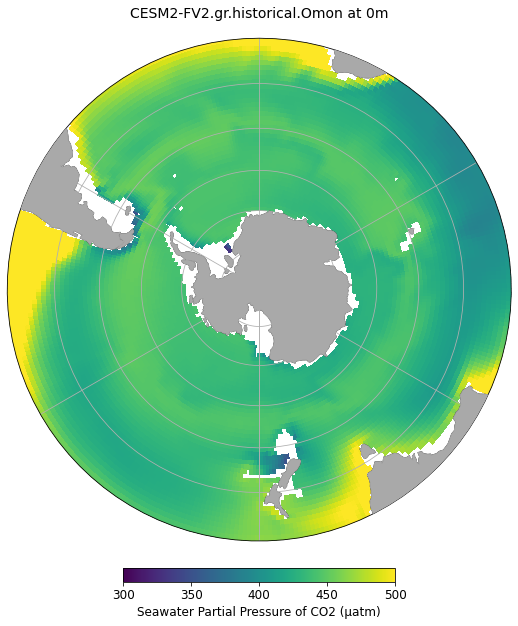

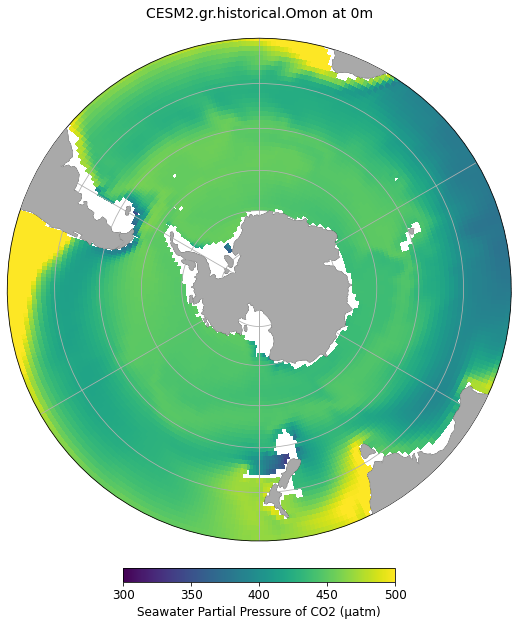

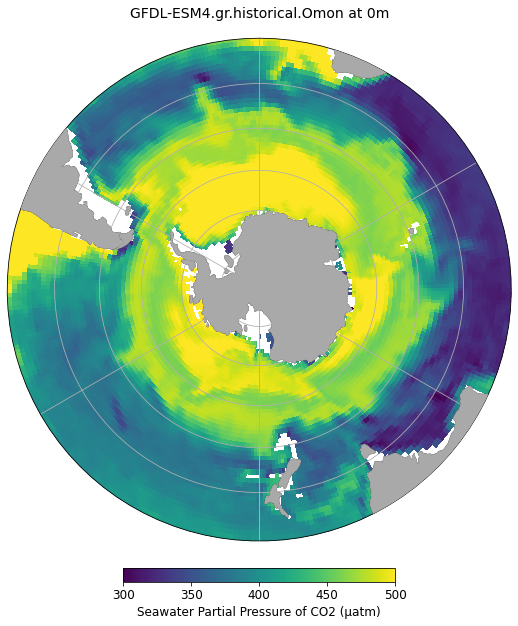

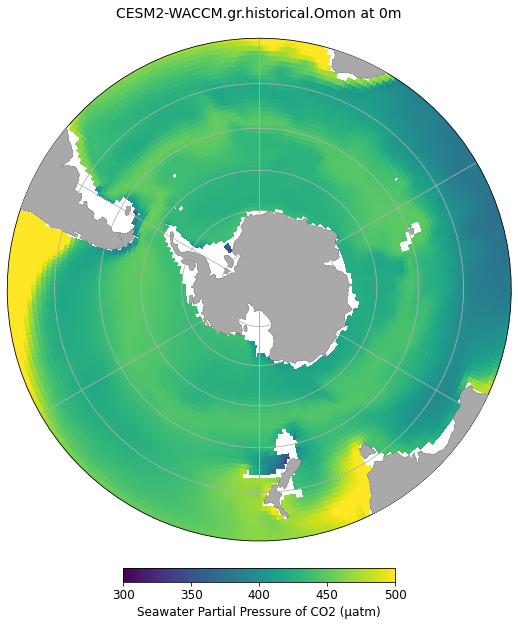

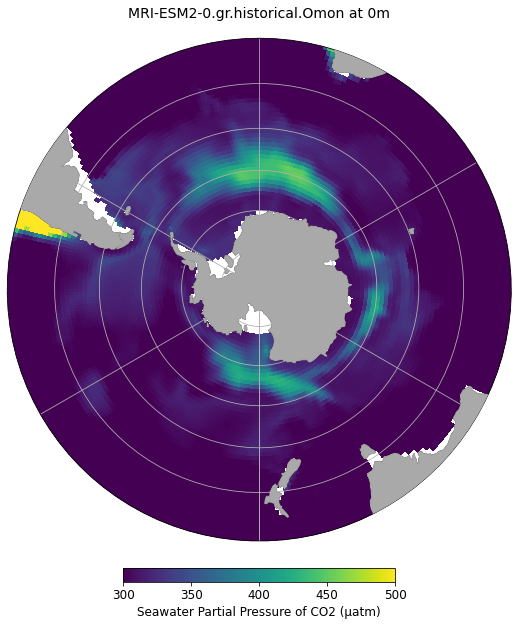

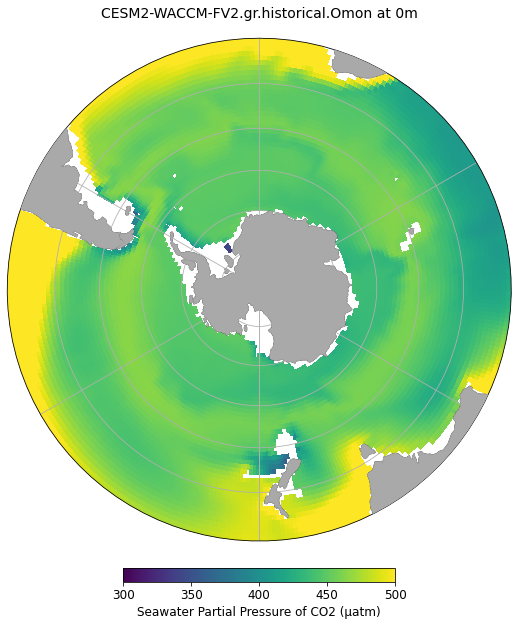

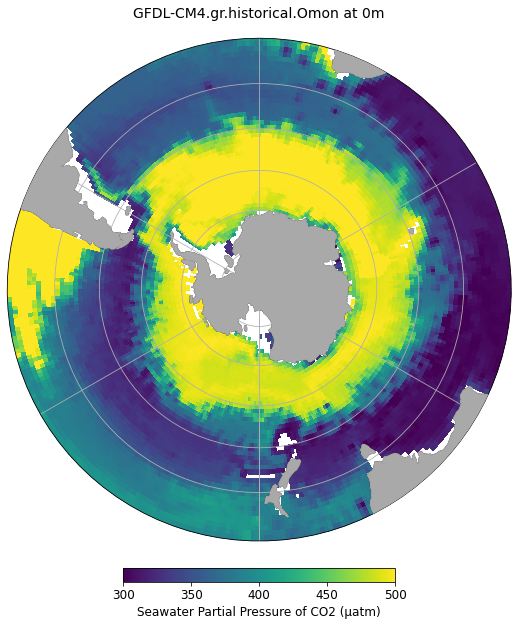

In [12]:
plt.rc('font', size = 12)
plt.rc('axes', titlesize= 10)    
plt.rc('axes', labelsize= 10)
plt.rc('figure', titlesize=14)

#loop over each key, value pair of the dictionary
ax_idx = 0 # index for your axes array
for name, ds in dd_new_new.items():

    # I selected the depth first 
    # in the hopes that having less values to average
    # it would go faster
    
    ds = ds.isel(lev = 16, time = 0)
    # .sel(lev = 800, method = nearest)
#     ds = ds.isel(time = slice(0, 239)).mean('time', keep_attrs=True)
    
    ds['pressure'] = xr.zeros_like(ds['thetao'])
    p = gsw.p_from_z(-1*ds['lev'], ds['pressure'], geo_strf_dyn_height=0, sea_surface_geopotential=0)
#     print(ds['pressure'])
    ds['insitutemp'] = gsw.t_from_CT(ds['so'], ds['thetao'], p) 
#     print(ds['insitutemp'])
    conversion =  1e6/1035
    results = pyco2.sys(par1=ds.talk*conversion,par2=ds.dissic*conversion,par1_type=1,par2_type=2,
                    pressure_out=0, temperature_out = ds.thetao, pressure = p, 
                    temperature = ds['insitutemp'])
    ds['pco2_out'] = ds['talk'].copy(data=results['pCO2_out'])
    surf = ds.pco2_out
#     print(surf)
    lat = ds.lat.transpose('y','x')
# #     print(lat)
    lon = ds.lon.transpose('y','x')
    draw_SOcustom(lon,lat,surf,cmap='viridis',cbar_label='Seawater Partial Pressure of CO2 (\u03BCatm)',
                  title=name+ ' at 0m',
                  plot_type='pcolormesh',clims=[300,500])

#     ax_idx += 1 # this is a nifty python trick to increment a variable by one
